In [1]:
import zarr
import xarray as xr
import matplotlib.pyplot as plt
import gzip
import pickle
import numpy as np
from sympl import get_constant

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

/home/data/miniconda3/lib/python3.8/site-packages/sympl/_core/dataarray.py:6: FutureWarning: xarray subclass DataArray should explicitly define __slots__
  class DataArray(xr.DataArray):


In [33]:
# %matplotlib notebook
from sympl import get_constant
from scipy import interpolate

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

Lv=2260000

lat1=13
lat2=19
lon1=35
lon2=41

common=xr.open_zarr("/home/scratch/Abel_data/long_run2/common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_1000",consolidated=False)
temp_clim=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind_clim=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind_clim=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press_clim=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress_clim=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens_clim=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent_clim=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*10000

def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

with gzip.open('/home/scratch/Abel_data/advection_meanv1', 'rb') as f:
    DSExmean, DSEymean, DSEzmean, windxmean, windymean, windzmean= pickle.load(f)

W=np.cos(lat_rad[1:-1,1:-1])*np.ones((len(p_std),4,4))
DSExmean=np.average(DSExmean, axis=(1,2), weights=W)
DSEymean=np.average(DSEymean, axis=(1,2), weights=W)
DSEzmean=np.average(DSEzmean, axis=(1,2), weights=W)
windxmean=np.average(windxmean, axis=(1,2), weights=W)
windymean=np.average(windymean, axis=(1,2), weights=W)
windzmean=np.average(windzmean, axis=(1,2), weights=W)

WXa=[]
WYa=[]
WZa=[]
DXa=[]
DYa=[]
DZa=[]

windx=[]
windy=[]
windz=[]
DSEx=[]
DSEy=[]
DSEz=[]

with gzip.open('/home/scratch/Abel_data/heat_indexv1', 'rb') as f:
    heat_index= pickle.load(f)
    
def interpol_time(X):
    
    t,h=np.shape(X)
    t_arr=np.linspace(0,1,t)
    t_std=np.array([0, 0.25, 0.5, 0.75, 1])
    out=np.zeros((5,h))
    
    for i in range(h):
        f = interpolate.interp1d(t_arr, X[:,i])
        out[:,i]=f(t_std)
            
    return out

test=0

for e in heat_index:
    
    if test==10:
        break
        
    test=test+1
    
    print(test)

    i=e[0]
    j=int(e[1])
    t_st=e[2][0]
    t_list=np.arange(t_st-15,t_st+5)
    print(t_list)
    ignore=0

    for t in t_list:
        
#         print(t)
        
#         t=t_0+k
        D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
        temp=D['air_temperature'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        uwind=D['eastward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        nwind=D['northward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        press=D['air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        spress=D['surface_air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        sens=D['surface_upward_sensible_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        latent=D['surface_upward_latent_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

        if np.min(press.values[0])<97000:
#             ignore=1
            print(np.min(press.values[0]))
            continue

        uwind=interpol1d(uwind, press)
        nwind=interpol1d(nwind, press)
        temp=interpol1d(temp, press)

        rho=(p_std[:,np.newaxis,np.newaxis]/(Rd*temp))[:,1:-1,1:-1]

        press_int=np.insert(p_std, 0, 101300)       

        # dz calculation

        dp=(press_int[:-1]-press_int[1:])

        dz=Rd*temp/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
        z=dz.cumsum(axis=0)

        dse=Cp*temp+g*z

        dudx=(uwind[:,1:-1,2:]-uwind[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
        dvdy=(nwind[:,2:,1:-1]*np.cos(lat_rad[2:,1:-1])-nwind[:,:-2,1:-1]*np.cos(lat_rad[:-2,1:-1]))/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))

        dwdp=-(dudx+dvdy)
        w=np.cumsum(dwdp*-dp[:,np.newaxis,np.newaxis],axis=0)

        windx.append(np.average(uwind[:,1:-1,1:-1],axis=(1,2), weights=W))
        DSEx.append(np.average(((dse[:,1:-1,2:]-dse[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*
                                                                  np.cos(lat_rad[1:-1,1:-1]))), axis=(1,2), weights=W))
        windy.append(np.average(nwind[:,1:-1,1:-1], axis=(1,2), weights=W))
        DSEy.append(np.average(((dse[:,2:,1:-1]-dse[:,:-2,1:-1])/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*
                                                                  6371*1000)),axis=(1,2), weights=W))

        
        windz.append(np.average(w, axis=(1,2), weights=W))
        dsez=uwind[:,1:-1,1:-1].copy()
        dsez[1:]=(dse[1:,1:-1,1:-1]-dse[:-1,1:-1,1:-1])/(-dp[1:,np.newaxis,np.newaxis])
        dsez[0]=(dse[1,1:-1,1:-1]-dse[0,1:-1,1:-1])/(-dp[1])
        DSEz.append(np.average(dsez, axis=(1,2), weights=W))

    
    if ignore==0:
        windxanom=np.array(windx)-windxmean
        windyanom=np.array(windy)-windymean
        windzanom=np.array(windz)-windzmean
        DSExanom=np.array(DSEx)-DSExmean
        DSEyanom=np.array(DSEy)-DSEymean
        DSEzanom=np.array(DSEz)-DSEzmean

        WXa.append((windxanom))
        WYa.append((windyanom))
        WZa.append((windzanom))
        DXa.append((DSExanom))
        DYa.append((DSEyanom))
        DZa.append((DSEzanom))
        
    windx=[]
    windy=[]
    windz=[]
    DSEx=[]
    DSEy=[]
    DSEz=[]
    
WXa=np.array(WXa)
WYa=np.array(WYa)
WZa=np.array(WZa)
DXa=np.array(DXa)
DYa=np.array(DYa)
DZa=np.array(DZa)

# print(np.shape(WZa))
with gzip.open('/home/scratch/Abel_data/profiles_individual', 'wb') as f:
    pickle.dump([WXa, WYa, WZa, DXa, DYa, DZa, windxmean, windymean, windzmean, DSExmean, DSEymean, DSEzmean], f)

1
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146]
2
[314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333]
3
[24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
4
[122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141]
5
[158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177]
6
[331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350]
7
[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34]
8
[137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156]
9
[187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206]
10
[217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236]


20


<IPython.core.display.Javascript object>


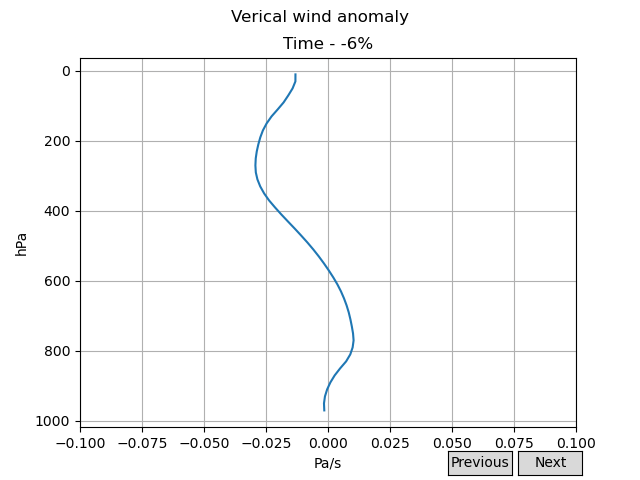

In [17]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import gzip
import pickle

p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*10000

with gzip.open('/home/scratch/Abel_data/profiles_individual', 'rb') as f:
    WXa, WYa, WZa, DXa, DYa, DZa, windxmean, windymean, windzmean, DSExmean, DSEymean, DSEzmean=pickle.load(f)

event_index=3
WZa=WZa[event_index]
print(len(WZa))
frac=np.array(range(len(WZa[0])))-15
current_index = 0
Field='Verical wind anomaly'

# Create the initial plot
mean=WZa[current_index,:]
fig, ax = plt.subplots()
fig.suptitle(Field)
             
line, = ax.plot(mean,p_std/100)
# ax.fill_betweenx(p_std/100, mean-std,mean+std, alpha =0.2)
ax.invert_yaxis()
ax.grid()
ax.set_title('Time - '+str(frac[current_index])+'%')
ax.set_xlim([-0.1, 0.1])
ax.set_xlabel('hPa/s')
ax.set_ylabel('hPa')
 
# Function to update the plot with the next portion of data
def update_plot(forward=True):
    global current_index
    
    step = 1 if forward else -1
    print(current_index)
    current_index += step
    if current_index < 0:
        current_index = 0
    elif current_index > len(frac):
        current_index = len(frac)
    
    mean=WZa[current_index,:]
#     std=WZa[current_index,:].std(axis=0)
    ax.cla()
    line, = ax.plot(mean,p_std/100)
#     ax.fill_betweenx(p_std/100, mean-std,mean+std, alpha =0.2)
    ax.invert_yaxis()
    ax.grid()
    ax.set_title('Time - '+str(frac[current_index])+'%')
    ax.set_xlim([-0.1, 0.1])
    ax.set_xlabel('Pa/s')
    ax.set_ylabel('hPa')
 
# Create buttons
ax_next_button = plt.axes([0.81, 0.01, 0.1, 0.05])
ax_prev_button = plt.axes([0.7, 0.01, 0.1, 0.05])
 
next_button = Button(ax_next_button, 'Next')
prev_button = Button(ax_prev_button, 'Previous')
 
# Connect buttons to update functions
next_button.on_clicked(lambda event: update_plot(forward=True))
prev_button.on_clicked(lambda event: update_plot(forward=False))
 
# Show the plot
plt.show()

<IPython.core.display.Javascript object>


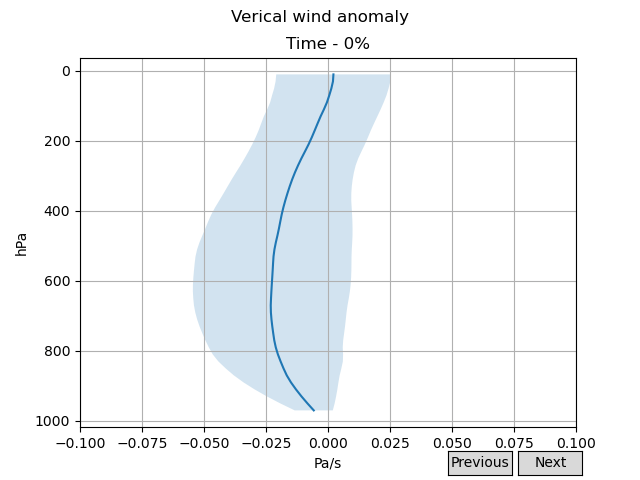

In [15]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import gzip
import pickle

p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*10000

with gzip.open('/home/scratch/Abel_data/profiles_individual', 'rb') as f:
    WXa, WYa, WZa, DXa, DYa, DZa, windxmean, windymean, windzmean, DSExmean, DSEymean, DSEzmean=pickle.load(f)

# WZa=np.array(WZa)
# event_index=5
# WZa=WZa[event_index]
frac=np.array(range(len(WZa[0])))-15
current_index = 0
Field='Verical wind anomaly'

# Create the initial plot
mean=WZa[:,current_index,:].mean(axis=0)
std=WZa[:,current_index,:].std(axis=0)
fig, ax = plt.subplots()
fig.suptitle(Field)
             
line, = ax.plot(mean,p_std/100)
ax.fill_betweenx(p_std/100, mean-std,mean+std, alpha =0.2)
ax.invert_yaxis()
ax.grid()
ax.set_title('Time - '+str(frac[current_index])+'%')
ax.set_xlim([-0.1, 0.1])
ax.set_xlabel('hPa/s')
ax.set_ylabel('hPa')
 
# Function to update the plot with the next portion of data
def update_plot(forward=True):
    global current_index
    
    step = 1 if forward else -1
    print(current_index)
    current_index += step
    if current_index < 0:
        current_index = 0
    elif current_index > 20:
        current_index = 20
    
    mean=WZa[:,current_index,:].mean(axis=0)
    std=WZa[:,current_index,:].std(axis=0)
    ax.cla()
    line, = ax.plot(mean,p_std/100)
    ax.fill_betweenx(p_std/100, mean-std,mean+std, alpha =0.2)
    ax.invert_yaxis()
    ax.grid()
    ax.set_title('Time - '+str(frac[current_index])+'%')
    ax.set_xlim([-0.1, 0.1])
    ax.set_xlabel('Pa/s')
    ax.set_ylabel('hPa')
 
# Create buttons
ax_next_button = plt.axes([0.81, 0.01, 0.1, 0.05])
ax_prev_button = plt.axes([0.7, 0.01, 0.1, 0.05])
 
next_button = Button(ax_next_button, 'Next')
prev_button = Button(ax_prev_button, 'Previous')
 
# Connect buttons to update functions
next_button.on_clicked(lambda event: update_plot(forward=True))
prev_button.on_clicked(lambda event: update_plot(forward=False))
 
# Show the plot
plt.show()